# Import everything

In [5]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

import multiprocessing
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz

# Import some MATLAB libraries
This helps us read .set files.

In [6]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [7]:
eegs = sorted(glob.glob('data/original/*/*/eeg/SP 110RMT r*/06-clean-prestimulus-hjorth.mat'))

# eegs = ['data/original/sub03/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub03/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub03/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub03/exp03/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub03/exp03/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub03/exp03/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub04/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub04/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub04/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
# #  'data/original/sub05/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',  # NO MEP
# #  'data/original/sub05/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',  # NO MEP
#  'data/original/sub05/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub06/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub06/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub06/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub06/exp02/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub07/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub07/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub07/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp02/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp03/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp03/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub08/exp03/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub09/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub10/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub10/exp02/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub10/exp02/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub10/exp02/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub11/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub12/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub12/exp02/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub12/exp03/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub12/exp03/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub12/exp03/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',        
#  'data/original/sub13/exp02/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat', # Left handed
#  'data/original/sub13/exp02/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat', # Left handed
#  'data/original/sub13/exp02/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat', # Left handed
# # 'data/original/sub14/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',   # BAD MEP
# #  'data/original/sub14/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat', # BAD MEP
# # 'data/original/sub14/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',   # BAD MEP
#  'data/original/sub15/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub15/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub15/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub16/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub16/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub16/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub17/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub18/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub18/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub18/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub19/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub19/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
#  'data/original/sub19/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat']

# Clean EEG rejected trials.
# rejected_trials = [
#     {'sub': 'sub03', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub03', 'exp': 'exp02', 'run': 'r2', 'trial': '*'},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': '*'},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': '*'},
#     {'sub': 'sub11', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub15', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub08', 'exp': 'exp03', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 38},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 11},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 15},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 16},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 17},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 24},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 25},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 26},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 27},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 28},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 29},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 30},
#     {'sub': 'sub12', 'exp': 'exp03', 'run': 'r1', 'trial': 32},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': 0},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 0},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 5},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 6},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 8},
#     {'sub': 'sub04', 'exp': 'exp01', 'run': 'r2', 'trial': 16},
#     {'sub': 'sub04', 'exp': 'exp01', 'run': 'r2', 'trial': 21},
#     {'sub': 'sub04', 'exp': 'exp01', 'run': 'r2', 'trial': 22},
#     {'sub': 'sub04', 'exp': 'exp01', 'run': 'r2', 'trial': 23},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 3},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 4},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 5},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 26},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 3},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 3},
#     {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 37},
#     {'sub': 'sub06', 'exp': 'exp02', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 0},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 3},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 11},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 45},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 46},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 47},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 48},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 49},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 38},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 24},
#     {'sub': 'sub08', 'exp': 'exp02', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 1},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 2},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 26},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 16},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 15},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 12},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 37},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 42},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 23},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 24},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 25},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 26},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 27},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 28},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 29},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 30},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 31},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 32},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 33},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 34},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 35},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 36},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 37},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 38},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 39},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 40},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 41},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 42},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 43},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 44},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 45},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 46},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 47},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 48},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 49},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub16', 'exp': 'exp01', 'run': 'r3', 'trial': 14},
#     {'sub': 'sub15', 'exp': 'exp01', 'run': 'r2', 'trial': 36},
#     {'sub': 'sub15', 'exp': 'exp01', 'run': 'r2', 'trial': 14},
#     {'sub': 'sub19', 'exp': 'exp01', 'run': 'r1', 'trial': 0}
# ]

# Hjorth rejected trials.
# rejected_trials = [
    
#     {'sub': 'sub03', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub03', 'exp': 'exp02', 'run': 'r2', 'trial': '*'},
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': '*'},
    
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # BAD MEP.
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # BAD MEP.
#     {'sub': 'sub14', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # BAD MEP.
#     {'sub': 'sub14', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # BAD MEP.
#     {'sub': 'sub14', 'exp': 'exp01', 'run': 'r3', 'trial': '*'}, # BAD MEP.
    
#     {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': '*'},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': '*'},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': '*'},
#     {'sub': 'sub11', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub16', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
#     {'sub': 'sub08', 'exp': 'exp03', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 38},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': 0},
#     {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 37},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 38},
#     {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 24},
#     {'sub': 'sub08', 'exp': 'exp02', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 1},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 2},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 26},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 18},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 17},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 16},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 15},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 13},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 12},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 11},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 10},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 9},
#     {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 8},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 15},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 31},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 37},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 41},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 37},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 42},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 23},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 24},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 25},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 26},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 27},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 28},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 29},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 30},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 31},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 32},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 33},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 34},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 35},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 36},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 37},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 38},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 39},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 40},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 41},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 42},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 43},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 44},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 45},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 46},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 47},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 48},
#     {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 49},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub18', 'exp': 'exp01', 'run': 'r2', 'trial': 26},
#     {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
#     {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
#     {'sub': 'sub08', 'exp': 'exp03', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
#     {'sub': 'sub16', 'exp': 'exp01', 'run': 'r3', 'trial': 14},
#     {'sub': 'sub15', 'exp': 'exp01', 'run': 'r2', 'trial': 36},
#     {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 0}, # Session log mentions there is no pulse.
#     {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 1}, # Session log mentions there is no pulse.
#     {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 48}, # Session log mentions there is no pulse.
#     {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 49}, # Session log mentions there is no pulse.
# ]

rejected_trials = [
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': '*'}, # We are using exp02 for this one
    
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # BAD MEP.
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # BAD MEP.
    
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 0}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 1}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 48}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 49}, # Session log mentions there is no pulse.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 17}, # Session log mentions there is a problem.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 18}, # Session log mentions there is a problem.
]

In [8]:
eegs

['data/original/sub02/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
 'data/original/sub02/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
 'data/original/sub02/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/06-clean-prestimulus-hjorth.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/06-clean-prestimulus-hjorth.mat',
 'data/original/sub04/exp02/eeg/SP 110RMT r1/06-clea

# Basic I/O and conversions.

In [9]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, 1000, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def read_trials_from_mat(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 1000, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({'C3': mat_trial[0], 'C4': mat_trial[1], 'time': time}))
    return trials

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def crop_mep_region(mep_frame, crop_start=0.211, crop_end=0.4):
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped

def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def calculate_mep_size(mep_frame, latency, duration):
    mep_cropped = crop_mep_region(mep_frame, latency, latency + duration)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

def read_latency_duration(eeg_path):
    segments = eeg_path.split('/')
    sub = segments[2]
    exp = segments[3]
    run = segments[5]
    path = 'data/original/' + sub + '/' + exp + '/mep/' + run + '/01-ld.csv'
    files = glob.glob(path)
    if len(files) < 1:
        return False
    fileMep = open(path, "r+")
    lines = fileMep.read().split('\n')
    df_ld = []
    for frame_txt in lines:
        if 'Frame' in frame_txt:
            continue
        segments = frame_txt.split('\t')
        if len(segments) >= 4:
            df_ld.append({
                'trial_num': int(segments[0])-1,
                'latency': float(segments[2]),
                'duration': float(segments[3]) - float(segments[2])
            })
    return pd.DataFrame(df_ld)

# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    columns = []
    ix = 0
    for r in df.index.values:
        if df[0][r] == 'Channel':
            ix = r
            break
    for c in df.columns.values:
        if (df[c][ix] == 2):
            columns.append(c)
    for r in df.index.values:
        if df[0][r] == 'Time (ms)':
            ix = r
            break
    df2 = df[columns].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    df2['time'] = df[0].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    return df2

# Identify CMAP peaks.
def find_cmap_peaks(df):
    df2 = df[(df['time'] > 105) * (df['time'] < 120)]
    time = df2['time']
    mean_clean = np.mean(df2.drop('time', axis=1), axis=1)
    return mean_clean.max(), mean_clean.min()

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1
    
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

def calculate_mep_categories_cmap_binary(mep_sizes, cmap):
    sizes = []
    for mep_size in mep_sizes:
        sizes.append(mep_size / cmap)
    p1 = np.percentile(sizes, 50)
    cat = np.ones(len(mep_sizes)) * (sizes >= p1)
    return cat

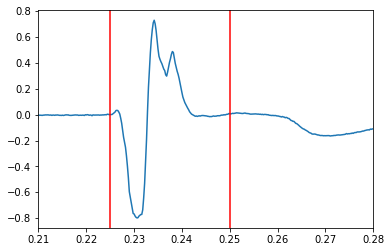

0.0138663662000004


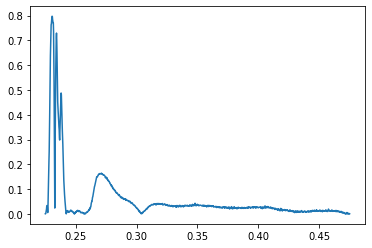

In [11]:
def calculate_mep_area(mep_frame, latency, duration, plot=False):
    apb_name = get_apb_column_name(mep_frame)
    mep_frame = mep_frame[(mep_frame['s'] >= latency) * (mep_frame['s'] <= latency + duration)]
    amplitude = mep_frame[apb_name]
    amplitude = np.abs(amplitude)
    time_diff = mep_frame['s'].iloc[1] - mep_frame['s'].iloc[0]
    area = trapz(amplitude, dx=time_diff)
    if (plot == True):
        plt.plot(mep_frame['s'], amplitude)
    return area
    
frames = open_mep_as_df(get_mep_path(eegs[30]))
mep_frame = frames[5]
plt.plot(mep_frame['s'], mep_frame['L APB'])
plt.xlim(.21, .28)
plt.axvline(0.225, color='r')
plt.axvline(0.25, color='r')
plt.show()
print(calculate_mep_area(mep_frame, 0.225, 0.25, plot=True))

In [12]:
frames = open_mep_as_df(get_mep_path(eegs[30]))

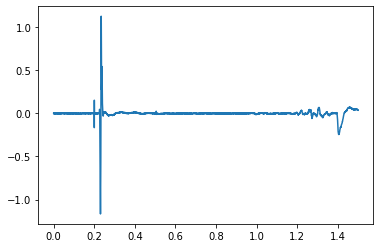

In [15]:
plt.plot(frames[0]['s'], frames[0]['L APB'])

In [17]:
frame = frames[0]
frame = frame[frame['s'] < 1]
frame.shape

(5000, 3)

# Power and phase calculations

In [69]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps=801):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype='bandpass', order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs=4096, plot=False, filter_type='butter'):
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], 4096), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['time'].values
    
    if plot == True:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,10))
        ax1.plot(time, channel)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title('Signal')
        
        ax2.plot(df_filtered['time'], df_filtered['channel'])
        ax2.set_title('Filtered channel')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Filtered channel')
        
        freq, power = signal.welch(df_filtered['channel'], 4096, nperseg=4096/2, nfft=4096/2)
        freq_res = freq[1] - freq[0]
        power = np.log(power)
        ax3.plot(freq[freq < 200], power[freq < 200])
        ax3.set_title('Power spectrum')
        ax3.set_xlabel('Frequency')
        ax3.set_ylabel('Power')
        
        ax4.plot(df_phase['time'], df_phase['phase'])
        ax4.plot(df_phase.iloc[-1]['time'], df_phase.iloc[-1]['phase'], 'o')
        ax4.set_title('Phase')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Phase')
        plt.tight_layout()
    # df_phase = df_phase[df_phase['time'] <= -20]
    return df_phase.iloc[-1]['phase'] + 180

def get_power(channel, time, band, crop_start_millis=-150, fs=500, plot=False, method='pburg', filter_type='butter'):       
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Resample.
    ts = time[1] - time[0]
    secs = len(channel) * ts
    secs = secs/1000
    resampled = signal.resample(channel, int(secs*fs))
    resampled_time = np.linspace(time[0], time[-1], len(resampled))
    
    # Filer if gamma region.
    if 48 > band[0] and 48 < band[1]:
        if filter_type == 'butter':
            resampled = butter_bandpass_filter(resampled, 48, 52, fs, 'bandstop')
            resampled_time = resampled_time
        else:
            df_filtered = blackman_harris_filter(resampled, resampled_time, [48, 52], fs, numtaps=101)
            resampled = df_filtered['channel']
            resampled_time = df_filtered['time']
    
    # PSD.
    try:
        if method == 'welch':
            # Welch method
            freq, power = signal.welch(resampled, fs, nperseg=4 * fs, nfft=4 * fs)
            freq_res = freq[1] - freq[0]
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
            # idx_band = np.logical_and(freq >= band[0], freq <= band[1])
            # mean_power = simps(power[idx_band], dx=freq_res)
        elif method == 'fft':
            # FFT method
            power = np.abs(np.fft.fft(resampled, n=500))
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
        elif method == 'pburg':
            # Burgs method
            p = pburg(resampled, int(len(resampled)/2), sampling=fs, NFFT=4096)
            power = p.psd
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power = df_power[df_power['freq'] < fs/2]
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
    except:
        return 0

    if plot == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,10))
        ax1.plot(time, channel)
        ax1.set_title('Signal')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax2.plot(resampled_time, resampled)
        ax2.set_title('Resampled')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Amplitude')
        ax3.plot(df_power['freq'], np.log(df_power['power']))
        ax3.axvspan(band[0], band[1], color='r', alpha=0.2)
        ax3.axhline(np.log(mean_power), color='r')
        ax3.set_xlabel('Frequency (Hz)')
        ax3.set_ylabel('Log Power')
        ax3.set_xlim([5, 100])
        ax3.set_title('Power spectrum')
        plt.tight_layout()

    return mean_power

data/original/sub14/exp01/eeg/SP 110RMT r1/06-clean-prestimulus-hjorth.mat


5.186488696375164

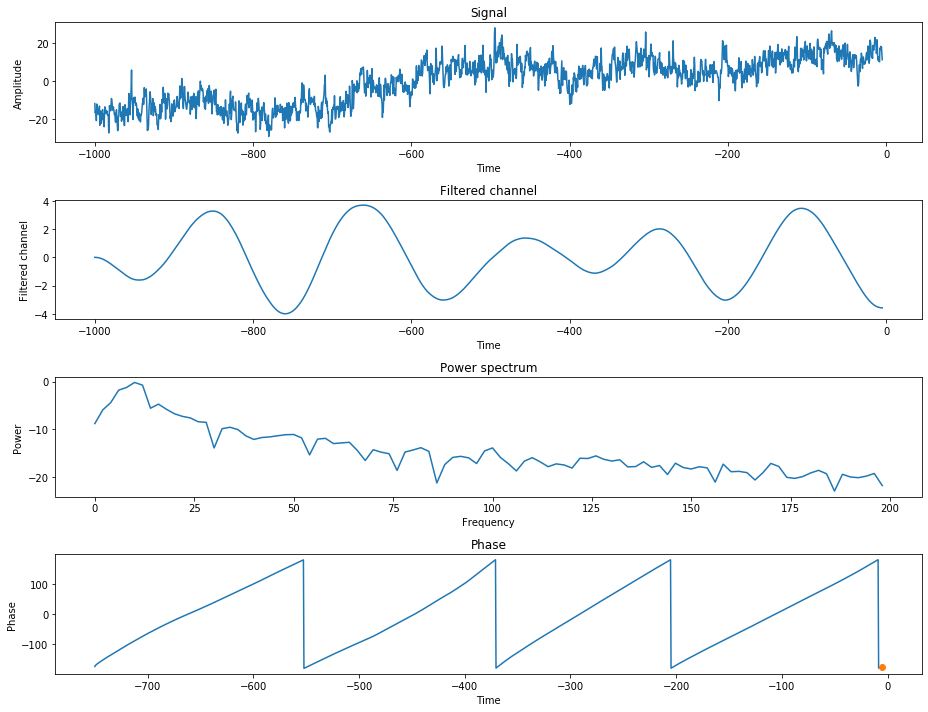

In [70]:
eeg_path = eegs[50]
print(eeg_path)
trials = read_trials_from_mat(eeg_path)
trial = trials[40]
trial = trial[trial['time'] < -5]

# get_power(trial['C3'], trial['time'], [8, 12], plot=True, method='welch')
# get_power(trial['C3'], trial['time'], [8, 12], plot=True, method='pburg')
# get_power(trial['C3'], trial['time'], [30, 80], plot=True)
get_phase(trial['C3'], trial['time'], [8, 12], plot=True)

# Combine EEG and others

In [71]:
def calculate_power_phase(trial, channel):    
    phase_power_dict = {}     
    phase_power_dict['theta_phase'] = get_phase(trial[channel], trial['time'], [3.5, 8])
    phase_power_dict['mu_phase'] = get_phase(trial[channel], trial['time'], [8, 12])
    phase_power_dict['beta_phase'] = get_phase(trial[channel], trial['time'], [13, 30])
    phase_power_dict['gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 80])
    phase_power_dict['low_beta_phase'] = get_phase(trial[channel], trial['time'], [12, 20])
    phase_power_dict['high_beta_phase'] = get_phase(trial[channel], trial['time'], [20, 30])
    phase_power_dict['low_gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 46])
    phase_power_dict['high_gamma_phase'] = get_phase(trial[channel], trial['time'], [46, 70])

    phase_power_dict['theta_power'] = get_power(trial[channel], trial['time'], [3.5, 8], crop_start_millis=-1000)
    phase_power_dict['mu_power'] = get_power(trial[channel], trial['time'], [8, 12])
    phase_power_dict['beta_power'] = get_power(trial[channel], trial['time'], [13, 30])
    phase_power_dict['gamma_power'] = get_power(trial[channel], trial['time'], [30, 80])
    phase_power_dict['low_beta_power'] = get_power(trial[channel], trial['time'], [12, 20])
    phase_power_dict['high_beta_power'] = get_power(trial[channel], trial['time'], [20, 30])
    phase_power_dict['low_gamma_power'] = get_power(trial[channel], trial['time'], [30, 46])
    phase_power_dict['high_gamma_power'] = get_power(trial[channel], trial['time'], [46, 70])
    return phase_power_dict
        
def process_trials(eeg_path):
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    
    files = glob.glob(os.path.dirname(eeg_path) + "/06-clean-prestimulus-hjorth.mat")
    if (len(files) == 0):
        return []
    
    trials = read_trials_from_mat(os.path.dirname(eeg_path) + "/06-clean-prestimulus-hjorth.mat")

    # Calculate CMAP.
    try:
        cmap_max, cmap_min = find_cmap_peaks(read_cmap(get_cmap_path(eeg_path)))
        cmap = cmap_max - cmap_min
    except:
        cmap = 0

    # Calculate MEP categories.
#     try:
#         mep_list = open_mep_as_df(get_mep_path(eeg_path))
#         mep_sizes = []
#         for mep_df in mep_list:
#             size, _, _ = calculate_mep_size(mep_df)
#             mep_sizes.append(size)
#         mep_cmap_list = calculate_mep_categories_cmap_binary(mep_sizes, cmap)
#         mep_percentile_list = calculate_mep_categories_binary(mep_sizes)
        
#         df_ld = read_latency_duration(eeg_path)
#         if isinstance(df_ld, pd.DataFrame) == False:
#             return []
#     except IndexError as e:
#         print('Skipping ' + sub + '/' + exp + '/' + run + ': MEP file error')
#         return []
    
    # Read latency duration
    df_ld = read_latency_duration(eeg_path)
    if isinstance(df_ld, pd.DataFrame) == False:
        return []
    
    # Calculate powers and phases. And combine the results in a df list.
    power_phase_list = []
    for trial_num in df_ld['trial_num'].values:
        if len(trials)-1 < trial_num:
            continue
        trial = trials[trial_num]
    
        # Ignore rejected trials.
        break_loop = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                print('Rejecting ' + sub + '/' + exp + '/' + run + '/' + str(rejected['trial']))
                break_loop = True
                break
        if break_loop == True or df_ld[df_ld['trial_num'] == trial_num].shape[0] == 0:
            continue
        
        # Calculate phase and power.
        print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        try:
            if sub in ['sub13', 'sub02']:
                channel = 'C4'
            else:
                channel = 'C3'
            power = calculate_power_phase(trial, channel)
        except ValueError as e:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': ' + str(e))
            continue

        latency = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['latency']
        duration = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['duration']
        mep_frame = open_mep_as_df(get_mep_path(eeg_path))[trial_num]
        mep_size, _, _ = calculate_mep_size(mep_frame, latency, duration)
        power_phase_dict = power
        power_phase_dict['sub'] = sub
        power_phase_dict['exp'] = exp
        power_phase_dict['run'] = run
        power_phase_dict['trial_num'] = trial_num
        power_phase_dict['cmap'] = cmap
        power_phase_dict['mep_size'] = mep_size
#         power_phase_dict['mep_cat_abs'] = get_mep_category_absolute_binary(mep_sizes[trial_num])
#         power_phase_dict['mep_cat_percentile'] = mep_percentile_list[trial_num]
#         power_phase_dict['mep_cat_cmap'] = mep_cmap_list[trial_num]
#         power_phase_dict['mep_by_cmap'] = mep_sizes[trial_num] / cmap
        power_phase_dict['mep_latency'] = latency - 0.20
        power_phase_dict['mep_duration'] = duration
        power_phase_dict['mep_area'] = calculate_mep_area(mep_frame, latency, duration)
        
        power_phase_dict['rejected'] = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                power_phase_dict['rejected'] = True
                break

        power_phase_list.append(power_phase_dict)
    return power_phase_list

In [72]:
num_cores = multiprocessing.cpu_count()-2
results = Parallel(n_jobs=num_cores)(delayed(process_trials)(eeg_path) for eeg_path in tqdm_notebook(eegs))

In [73]:
sub_map = {
    'sub01': 'Terry Baedon',
    'sub02': 'David Brown',
    'sub03': 'Sarah Brunet',
    'sub04': 'Lynette Gallaty',
    'sub05': 'Mana Higashihara',
    'sub06': 'Tim Howells',
    'sub07': 'Merolene Pirsarkiewicz',
    'sub08': 'Steve Vucic',
    'sub09': 'Hayeley Turnbull',
    'sub10': 'Nimeshan Geevasinga',
    'sub11': 'Amarissa M',
    'sub12': 'Marshall Owen',
    'sub13': 'Stephen Schebeci',
    'sub14': 'Matt Silsby',
    'sub15': 'Carlos Brito',
    'sub16': 'Alistair McEwan',
    'sub17': 'Toni Mathieson',
    'sub18': 'Karen Robertson',
    'sub19': 'Julie Terry',
    'sub20': 'Natalie Terry',
    'sub21': 'Raquib-ul Alam',
    'sub22': 'Lin Gavin',
}

In [74]:
df_powers = []
for result in results:
    if len(result) == 0:
        continue
    for trial in result:
        df_powers.append(trial)
len(df_powers)

df_power = pd.DataFrame(df_powers)
print(df_power.shape)

df_power['name'] = df_power.apply(lambda x: sub_map[x['sub']], axis=1)
df_power.to_excel('139-new-ld-v3.xlsx')

(2863, 26)
